# Generational changes in religious attitudes

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import pandas as pd
import numpy as np

import thinkstats2
import thinkplot
import utils

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='whitegrid', font_scale=1.5)

from scipy.special import expit

Reading data from the [General Social Survey](https://gssdataexplorer.norc.org/projects/29853)

In [2]:
# !wget https://gssdataexplorer.norc.org/extracts/21438/download

In [3]:
gss = utils.ReadGss('gss_religion_data')
print(gss.shape)
gss.head()

(62466, 11)


,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,god
0,1972,0,0,1949,23,0.4446,0,3,16,1,0
1,1972,0,0,1902,70,0.8893,0,2,10,2,0
2,1972,0,0,1924,48,0.8893,0,1,12,3,0
3,1972,0,0,1945,27,0.8893,0,5,17,4,0
4,1972,0,0,1911,61,0.8893,0,1,12,5,0


Cleaning variables

In [4]:
# TODO: find out what code 4 is

gss.bible.replace([4, 8, 9, 0], np.nan, inplace=True)

In [5]:
utils.values(gss, 'bible')

1.0    11185
2.0    15926
3.0     5929
Name: bible, dtype: int64

In [6]:
gss.conclerg.replace([8, 9, 0], np.nan, inplace=True)

In [7]:
utils.values(gss, 'conclerg')

1.0    11366
2.0    20886
3.0     8660
Name: conclerg, dtype: int64

In [8]:
gss.god.replace([8, 9, 0], np.nan, inplace=True)
sum(gss.god.isnull())

40129

In [9]:
utils.values(gss, 'god')

1.0      673
2.0     1110
3.0     2286
4.0      900
5.0     3662
6.0    13706
Name: god, dtype: int64

In [10]:
gss.age.replace([98, 99], np.nan, inplace=True)
sum(gss.age.isnull())

221

In [11]:
gss.cohort.replace([9999], np.nan, inplace=True)
sum(gss.cohort.isnull())

221

In [12]:
gss.relig.replace([98, 99], np.nan, inplace=True)
sum(gss.relig.isnull())

269

In [13]:
gss.dropna(subset=['age', 'cohort', 'relig'], inplace=True)
gss.shape

(61995, 11)

We drop 471 records due to missing data.

In [14]:
62466 - 61995

471

Here's the distribution of ages.

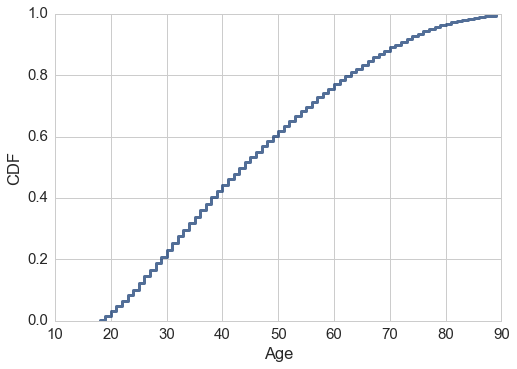

In [15]:
thinkplot.Cdf(thinkstats2.Cdf(gss.age))
thinkplot.Config(xlabel='Age', ylabel='CDF')

Group people into 5-year age groups.

In [16]:
gss['age_group'] = utils.RoundIntoBins(gss, 'age', 5) + 2.5

Here's the distribution of birth year.

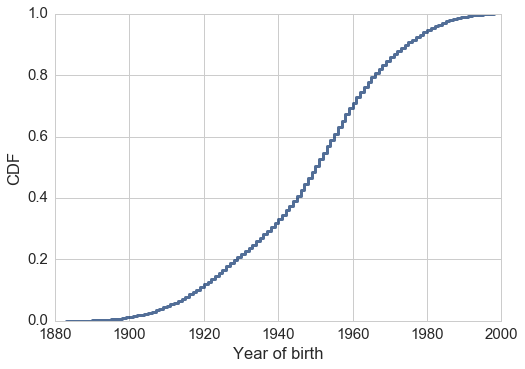

In [17]:
thinkplot.Cdf(thinkstats2.Cdf(gss.cohort))
thinkplot.Config(xlabel='Year of birth', ylabel='CDF')

Group people into 5- and 10-year bins by birth year.

In [18]:
gss['cohort5'] = utils.RoundIntoBins(gss, 'cohort', 5) + 2.5

In [19]:
gss['cohort10'] = utils.RoundIntoBins(gss, 'cohort', 10)

Here's the distribution of religion codes.

In [20]:
utils.values(gss, 'relig')

1.0     35856
2.0     15136
3.0      1233
4.0      7231
5.0      1064
6.0       177
7.0        88
8.0        38
9.0       135
10.0      112
11.0      760
12.0       30
13.0      135
Name: relig, dtype: int64

Resampling (bootstrapping to be more specific) to account for sampling weights.

In [21]:
sample = utils.ResampleByYear(gss)
sample.head()

,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,god,age_group,cohort5,cohort10
0,1972,NaN,NaN,1927.0,45.0,0.8893,0,2.0,12,1497,NaN,47.5,1927.5,1920.0
1,1972,NaN,NaN,1954.0,18.0,0.8893,0,2.0,12,420,NaN,17.5,1952.5,1950.0
2,1972,NaN,NaN,1899.0,73.0,0.8893,0,2.0,12,804,NaN,72.5,1897.5,1890.0
3,1972,NaN,NaN,1917.0,55.0,1.3339,0,1.0,5,1605,NaN,57.5,1917.5,1910.0
4,1972,NaN,NaN,1908.0,64.0,0.8893,0,2.0,11,230,NaN,62.5,1907.5,1900.0


## How does religious affiliation change with age?

In [22]:
varnames = ['prot', 'cath', 'none', 'other']

def create_relig_vars(df):
    """Creates columns for religious categories.
    
    df: DataFrame
    """
    # the second line lumps "Orthodox-Christian" and "Christian" with Protestant
    #df['prot'] = (df.relig==1)
    df['prot'] = (df.relig.isin([1,10,11]))

    df['cath'] = (df.relig==2)
    df['none'] = (df.relig==4)
    df['other'] = (df.relig.isin([3,5,6,7,8,9,12,13]))
    
    df['relig4'] = df.relig.copy()
    df.relig4.replace([10, 11], 1, inplace=True)
    df.relig4.replace([5,6,7,8,9,12,13], 3, inplace=True)

    df.loc[df.relig.isnull(), varnames + ['relig4']] = np.nan
    
create_relig_vars(sample)

Group by decade of birth and age group.

In [23]:
grouped = sample.groupby(['cohort10', 'age_group'])

Count the number of observations in each decade/age group.

In [24]:
counts = grouped.none.count().unstack()
counts

age_group,17.5,22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5,87.5
cohort10,,,,,,,,,,,,,,,
1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,33.0
1890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,183.0,122.0,112.0
1900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0,418.0,481.0,304.0,257.0,161.0
1910.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.0,638.0,729.0,724.0,614.0,460.0,252.0,163.0
1920.0,NaN,NaN,NaN,NaN,NaN,74.0,718.0,999.0,943.0,897.0,777.0,553.0,385.0,280.0,167.0
1930.0,NaN,NaN,NaN,86.0,633.0,1033.0,930.0,957.0,838.0,727.0,663.0,486.0,382.0,180.0,17.0
1940.0,NaN,118.0,818.0,1092.0,1188.0,1292.0,1335.0,1247.0,1071.0,886.0,668.0,307.0,31.0,NaN,NaN
1950.0,344.0,1567.0,1572.0,1642.0,1619.0,1640.0,1589.0,1303.0,1071.0,570.0,69.0,NaN,NaN,NaN,NaN
1960.0,310.0,1604.0,1537.0,1666.0,1524.0,1452.0,1063.0,694.0,108.0,NaN,NaN,NaN,NaN,NaN,NaN


Compute the percentage of Nones in each group.

In [25]:
percent_none = grouped.none.mean().unstack()
percent_none

age_group,17.5,22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5,87.5
cohort10,,,,,,,,,,,,,,,
1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000,0.000000
1890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.038251,0.024590,0.035714
1900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013333,0.028708,0.035343,0.032895,0.031128,0.049689
1910.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010101,0.028213,0.031550,0.044199,0.055375,0.021739,0.059524,0.049080
1920.0,NaN,NaN,NaN,NaN,NaN,0.054054,0.040390,0.027027,0.046660,0.027871,0.036036,0.043400,0.059740,0.089286,0.071856
1930.0,NaN,NaN,NaN,0.069767,0.066351,0.045499,0.052688,0.033438,0.039379,0.037139,0.069382,0.084362,0.065445,0.094444,0.235294
1940.0,NaN,0.144068,0.094132,0.082418,0.088384,0.071207,0.072659,0.083400,0.098039,0.104966,0.122754,0.097720,0.225806,NaN,NaN
1950.0,0.139535,0.114231,0.127226,0.082217,0.089561,0.123780,0.120831,0.132003,0.143791,0.161404,0.101449,NaN,NaN,NaN,NaN
1960.0,0.116129,0.111596,0.112557,0.142857,0.172572,0.137052,0.170273,0.162824,0.166667,NaN,NaN,NaN,NaN,NaN,NaN


Drop cells where we have fewer than 50 observations.

In [26]:
percent_none[counts < 50] = np.nan

Select rows for people born in the 1930s through 1980s.

In [27]:
decades = np.linspace(1930, 1980, 6, endpoint=True)
percent_none.loc[decades]

age_group,17.5,22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5,87.5
cohort10,,,,,,,,,,,,,,,
1930.0,NaN,NaN,NaN,0.069767,0.066351,0.045499,0.052688,0.033438,0.039379,0.037139,0.069382,0.084362,0.065445,0.094444,NaN
1940.0,NaN,0.144068,0.094132,0.082418,0.088384,0.071207,0.072659,0.083400,0.098039,0.104966,0.122754,0.097720,NaN,NaN,NaN
1950.0,0.139535,0.114231,0.127226,0.082217,0.089561,0.123780,0.120831,0.132003,0.143791,0.161404,0.101449,NaN,NaN,NaN,NaN
1960.0,0.116129,0.111596,0.112557,0.142857,0.172572,0.137052,0.170273,0.162824,0.166667,NaN,NaN,NaN,NaN,NaN,NaN
1970.0,0.151408,0.204097,0.182259,0.203175,0.223346,0.221311,0.222222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980.0,0.175227,0.289430,0.293578,0.272321,0.316239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Choose some colors.

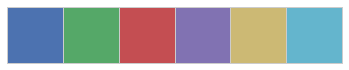

In [28]:
colors = sns.color_palette()
sns.palplot(colors)

For each birth cohort, plot the percentage of Nones as a function of age.

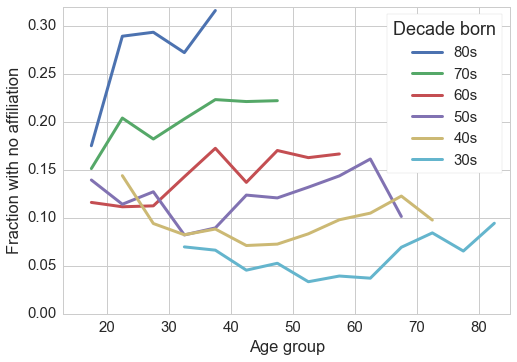

In [29]:
options = dict(alpha=1)

thinkplot.preplot(6)
thinkplot.plot(percent_none.loc[1980], label='80s', color=colors[0], **options)
thinkplot.plot(percent_none.loc[1970], label='70s', color=colors[1], **options)
thinkplot.plot(percent_none.loc[1960], label='60s', color=colors[2], **options)
thinkplot.plot(percent_none.loc[1950], label='50s', color=colors[3], **options)
thinkplot.plot(percent_none.loc[1940], label='40s', color=colors[4], **options)
thinkplot.plot(percent_none.loc[1930], label='30s', color=colors[5], **options)

xlabel = 'Age group'
ylabel = 'Fraction with no affiliation'
axis = [13, 85, 0, 0.32]

thinkplot.config(xlabel=xlabel, ylabel=ylabel, axis=axis, legend=True)
plt.gca().get_legend().set(title='Decade born');

Same as the previous, but as a multi-plot.

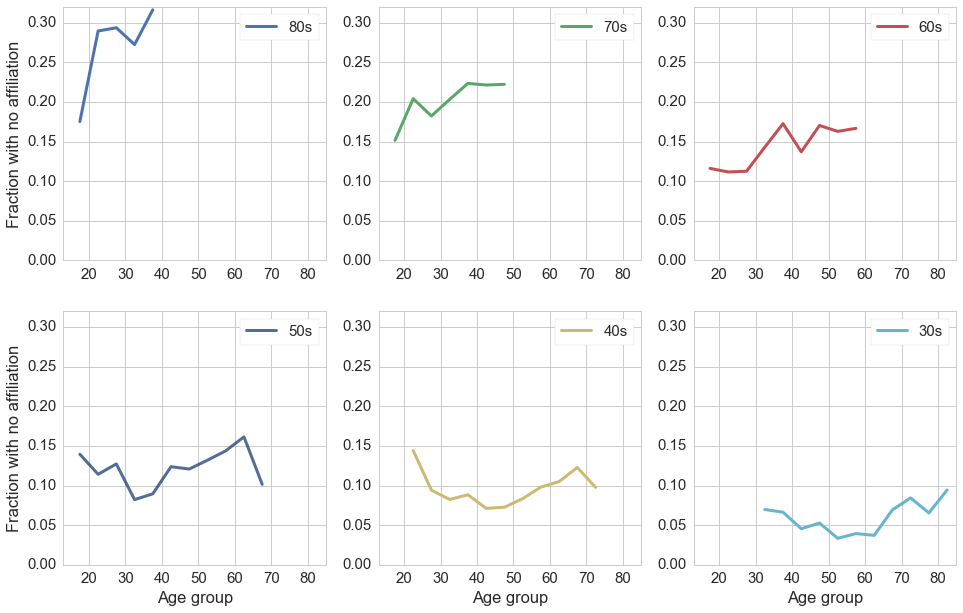

In [30]:
thinkplot.preplot(num=6, rows=2, cols=3)
thinkplot.subplot(1)
thinkplot.plot(percent_none.loc[1980], label='80s', color=colors[0], **options)
thinkplot.config(ylabel=ylabel, axis=axis)

thinkplot.subplot(2)
thinkplot.plot(percent_none.loc[1970], label='70s', color=colors[1], **options)
thinkplot.config(axis=axis)

thinkplot.subplot(3)
thinkplot.plot(percent_none.loc[1960], label='60s', color=colors[2], **options)
thinkplot.config(axis=axis)

thinkplot.subplot(4)
thinkplot.plot(percent_none.loc[1950], label='50s')
thinkplot.config(xlabel=xlabel, ylabel=ylabel, axis=axis, color=colors[3], **options)

thinkplot.subplot(5)
thinkplot.plot(percent_none.loc[1940], label='40s', color=colors[4], **options)
thinkplot.config(xlabel=xlabel, axis=axis)

thinkplot.subplot(6)
thinkplot.plot(percent_none.loc[1930], label='30s', color=colors[5], **options)
thinkplot.config(xlabel=xlabel, axis=axis)

In [31]:
def center_factors(df):
    """Center factors around their means.
    
    df: DataFrame
    """
    df['cohort66'] = df.cohort - 1966
    df['cohort662'] = df.cohort66**2 / 1966
    df['age47'] = df.age - 47
    df['age472'] = df.age47**2 / 47

In [32]:
center_factors(sample)

In [33]:
formula = 'prot ~ cohort66 + cohort662 + age47 + age472'
results = smf.logit(formula, data=sample).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.665699
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   prot   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61990
Method:                           MLE   Df Model:                            4
Date:                Sun, 28 May 2017   Pseudo R-squ.:                 0.02068
Time:                        20:36:57   Log-Likelihood:                -41270.
converged:                       True   LL-Null:                       -42141.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1000      0.016      6.066      0.000       0.068       0.132
cohort66      -0.0195      0.001    -22.079      0.000      -0.021      -0.018
cohort662     -0.1999      0.036     -5.526      0.000      -0.271      -0.129
age47          0.0013      0.001      1.649      0.099      -0.000       0.003
age472        -0.0016      0.001     -1.098      0.272      -0.005       0.001
==============================================================================
"""

In [34]:
formula = 'cath ~ cohort66 + cohort662 + age47 + age472'
results = smf.logit(formula, data=sample).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.568178
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   cath   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61990
Method:                           MLE   Df Model:                            4
Date:                Sun, 28 May 2017   Pseudo R-squ.:                0.002092
Time:                        20:36:57   Log-Likelihood:                -35224.
converged:                       True   LL-Null:                       -35298.
                                        LLR p-value:                 6.320e-31
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1417      0.019    -60.849      0.000      -1.178      -1.105
cohort66      -0.0053      0.001     -5.409      0.000      -0.007      -0.003
cohort662     -0.1330      0.040     -3.316      0.001      -0.212      -0.054
age47         -0.0084      0.001     -9.613      0.000      -0.010      -0.007
age472         0.0022      0.002      1.346      0.178      -0.001       0.005
==============================================================================
"""

In [35]:
formula = 'none ~ cohort66 + cohort662 + age47 + age472'
results = smf.logit(formula, data=sample).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.334176
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   none   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61990
Method:                           MLE   Df Model:                            4
Date:                Sun, 28 May 2017   Pseudo R-squ.:                 0.06288
Time:                        20:36:58   Log-Likelihood:                -20717.
converged:                       True   LL-Null:                       -22107.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5425      0.024    -64.633      0.000      -1.589      -1.496
cohort66       0.0422      0.001     34.749      0.000       0.040       0.045
cohort662     -0.0076      0.064     -0.118      0.906      -0.134       0.118
age47          0.0136      0.001     10.326      0.000       0.011       0.016
age472         0.0083      0.003      3.240      0.001       0.003       0.013
==============================================================================
"""

In [36]:
formula = 'other ~ cohort66 + cohort662 + age47 + age472'
results = smf.logit(formula, data=sample).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.188894
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  other   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61990
Method:                           MLE   Df Model:                            4
Date:                Sun, 28 May 2017   Pseudo R-squ.:                0.003195
Time:                        20:36:58   Log-Likelihood:                -11710.
converged:                       True   LL-Null:                       -11748.
                                        LLR p-value:                 1.918e-15
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8279      0.037    -76.756      0.000      -2.900      -2.756
cohort66       0.0084      0.002      4.255      0.000       0.005       0.012
cohort662     -0.1073      0.085     -1.265      0.206      -0.273       0.059
age47          0.0041      0.002      2.252      0.024       0.001       0.008
age472        -0.0013      0.003     -0.386      0.699      -0.008       0.005
==============================================================================
"""

## Generational replacement

Choose colors

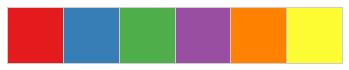

In [37]:
RED, BLUE, GREEN, PURPLE, ORANGE, YELLOW = sns.color_palette('Set1')
sns.palplot(sns.color_palette('Set1'))

In [38]:
def make_series_seq(grouped, varnames):
    """Compute the percentage in each category.
    
    grouped: GroupBy object with one-hots for each category
    varnames: list of string column names
    
    returns: list of Series
    """
    return [grouped[var].mean() * 100 for var in varnames]

def plot_series_seq(series_seq, colors, labels):
    """Plots Series objects.
    
    series_seq: list of Series
    colors: list of string colors
    labels: list of string labels
    """
    for series, color, label in zip(series_seq, colors, labels):
        thinkplot.plot(series, color=color, label=label)

In [39]:
colors = [ORANGE, GREEN, RED, BLUE]
    
def plot_relig(grouped):
    """Plot one line for each religious group.
    
    grouped: GroupBy object with one-hots for each religious group
    """
    labels = ['Protestant', 'Catholic', 'None', 'Other']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

Plot the percentage in each religious group as a function of interview year.

In [40]:
grouped_year = sample.groupby(['year'])
grouped_year.none.count()

year
1972    1603
1973    1496
1974    1477
1975    1483
1976    1491
1977    1516
1978    1522
1980    1456
1982    1837
1983    1588
1984    1456
1985    1522
1986    1460
1987    1802
1988    1476
1989    1530
1990    1367
1991    1513
1993    1592
1994    2976
1996    2894
1998    2792
2000    2805
2002    2735
2004    2792
2006    4468
2008    2004
2010    2028
2012    1962
2014    2513
2016    2839
Name: none, dtype: int64

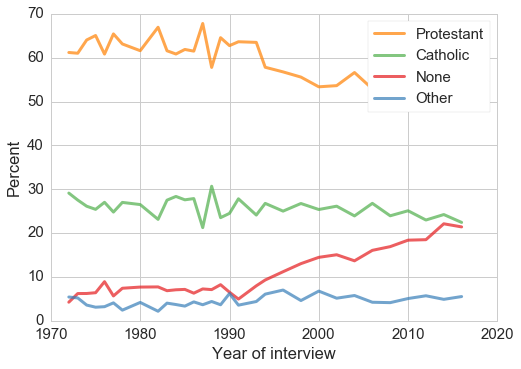

In [41]:
plot_relig(grouped_year)
thinkplot.config(xlabel='Year of interview', ylabel='Percent')

In [42]:
grouped_age = sample.groupby(['age_group'])
grouped_age.none.count()

age_group
17.5    1518
22.5    6379
27.5    6569
32.5    6418
37.5    6169
42.5    6101
47.5    5698
52.5    5299
57.5    4669
62.5    3884
67.5    3319
72.5    2478
77.5    1745
82.5    1096
87.5     653
Name: none, dtype: int64

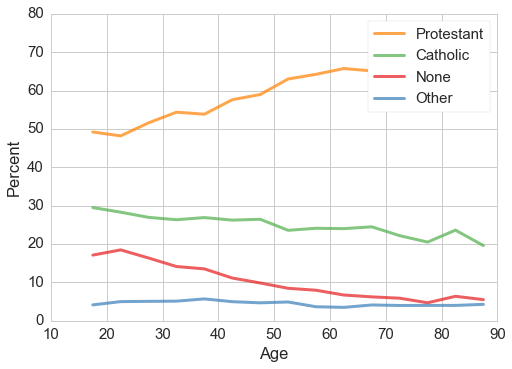

In [43]:
plot_relig(grouped_age)
thinkplot.config(xlabel='Age', ylabel='Percent')

Plot the percentage in each religious group as a function of birth cohort.

In [44]:
grouped_cohort = sample.groupby(['cohort5'])
grouped_cohort.relig.count()

cohort5
1882.5       1
1887.5      37
1892.5     128
1897.5     326
1902.5     612
1907.5    1084
1912.5    1491
1917.5    2188
1922.5    2699
1927.5    3094
1932.5    3162
1937.5    3770
1942.5    4410
1947.5    5643
1952.5    6420
1957.5    6566
1962.5    5576
1967.5    4382
1972.5    3395
1977.5    2720
1982.5    2088
1987.5    1314
1992.5     671
1997.5     218
Name: relig, dtype: int64

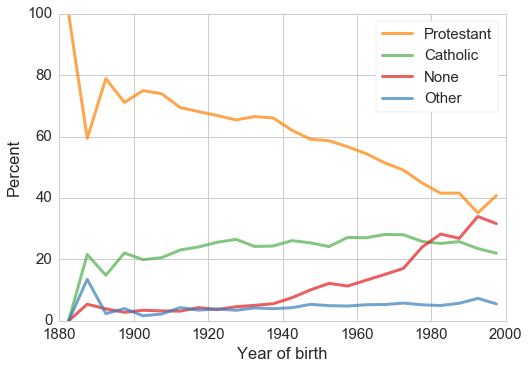

In [45]:
plot_relig(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent')

Before running models, center the factors we're planning to use.

In [46]:
def center_factors(df):
    """Center factors around their means.
    
    Add centered factors for the model.
    
    df: DataFrame
    cohort: Series
    age: Series
    """
    df['c'] = df.cohort - 1966
    df['c2'] = df.c**2
    df['a'] = df.age - 47
    df['a2'] = df.a**2
    df['ac'] = df.a * df.c

In [47]:
center_factors(sample)
sample.head()

,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,...,relig4,cohort66,cohort662,age47,age472,c,c2,a,a2,ac
0,1972,NaN,NaN,1927.0,45.0,0.8893,0,2.0,12,1497,...,2.0,-39.0,0.773652,-2.0,0.085106,-39.0,1521.0,-2.0,4.0,78.0
1,1972,NaN,NaN,1954.0,18.0,0.8893,0,2.0,12,420,...,2.0,-12.0,0.073245,-29.0,17.893617,-12.0,144.0,-29.0,841.0,348.0
2,1972,NaN,NaN,1899.0,73.0,0.8893,0,2.0,12,804,...,2.0,-67.0,2.283316,26.0,14.382979,-67.0,4489.0,26.0,676.0,-1742.0
3,1972,NaN,NaN,1917.0,55.0,1.3339,0,1.0,5,1605,...,1.0,-49.0,1.221261,8.0,1.361702,-49.0,2401.0,8.0,64.0,-392.0
4,1972,NaN,NaN,1908.0,64.0,0.8893,0,2.0,11,230,...,2.0,-58.0,1.711089,17.0,6.148936,-58.0,3364.0,17.0,289.0,-986.0


Run logistic regression to fit models to each religious group.

In [48]:
def make_model(df, var):
    """Fit a logistic regression model.
    
    df: DataFrame
    var: string name of dependent variable
    """
    formula = var + ' ~ c + c2 + a + a2 + ac'
    return smf.logit(formula, data=df).fit()

In [49]:
make_model(sample, 'prot').summary()

Optimization terminated successfully.
         Current function value: 0.665541
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   prot   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61989
Method:                           MLE   Df Model:                            5
Date:                Sun, 28 May 2017   Pseudo R-squ.:                 0.02091
Time:                        20:37:01   Log-Likelihood:                -41260.
converged:                       True   LL-Null:                       -42141.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0550      0.019      2.838      0.005       0.017       0.093
c             -0.0280      0.002    -13.260      0.000      -0.032      -0.024
c2            -0.0003   5.31e-05     -6.069      0.000      -0.000      -0.000
a             -0.0080      0.002     -3.570      0.000      -0.012      -0.004
a2            -0.0003   6.66e-05     -4.428      0.000      -0.000      -0.000
ac            -0.0005      0.000     -4.430      0.000      -0.001      -0.000
==============================================================================
"""

In [50]:
make_model(sample, 'cath').summary()

Optimization terminated successfully.
         Current function value: 0.568176
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   cath   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61989
Method:                           MLE   Df Model:                            5
Date:                Sun, 28 May 2017   Pseudo R-squ.:                0.002095
Time:                        20:37:02   Log-Likelihood:                -35224.
converged:                       True   LL-Null:                       -35298.
                                        LLR p-value:                 3.750e-30
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1469      0.022    -51.496      0.000      -1.191      -1.103
c             -0.0063      0.002     -2.629      0.009      -0.011      -0.002
c2         -9.184e-05   5.93e-05     -1.549      0.121      -0.000    2.43e-05
a             -0.0095      0.003     -3.733      0.000      -0.014      -0.004
a2          1.843e-05   7.47e-05      0.247      0.805      -0.000       0.000
ac         -5.334e-05      0.000     -0.434      0.664      -0.000       0.000
==============================================================================
"""

In [51]:
make_model(sample, 'none').summary()

Optimization terminated successfully.
         Current function value: 0.333886
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   none   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61989
Method:                           MLE   Df Model:                            5
Date:                Sun, 28 May 2017   Pseudo R-squ.:                 0.06369
Time:                        20:37:02   Log-Likelihood:                -20699.
converged:                       True   LL-Null:                       -22107.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4684      0.027    -55.239      0.000      -1.521      -1.416
c              0.0592      0.003     19.263      0.000       0.053       0.065
c2             0.0005   8.51e-05      5.543      0.000       0.000       0.001
a              0.0319      0.003      9.690      0.000       0.025       0.038
a2             0.0007      0.000      6.899      0.000       0.001       0.001
ac             0.0011      0.000      6.049      0.000       0.001       0.001
==============================================================================
"""

In [52]:
make_model(sample, 'other').summary()

Optimization terminated successfully.
         Current function value: 0.188870
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  other   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61989
Method:                           MLE   Df Model:                            5
Date:                Sun, 28 May 2017   Pseudo R-squ.:                0.003325
Time:                        20:37:02   Log-Likelihood:                -11709.
converged:                       True   LL-Null:                       -11748.
                                        LLR p-value:                 2.068e-15
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8668      0.043    -65.989      0.000      -2.952      -2.782
c              0.0008      0.005      0.159      0.874      -0.009       0.010
c2            -0.0003      0.000     -2.070      0.038      -0.000   -1.36e-05
a             -0.0042      0.005     -0.823      0.410      -0.014       0.006
a2            -0.0003      0.000     -1.710      0.087      -0.001    3.94e-05
ac            -0.0004      0.000     -1.738      0.082      -0.001     5.7e-05
==============================================================================
"""

In [53]:
formula = 'relig4 ~ c + c2 + a + a2 + ac'
model = smf.mnlogit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 1.028973
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                 relig4   No. Observations:                61995
Model:                        MNLogit   Df Residuals:                    61977
Method:                           MLE   Df Model:                           15
Date:                Sun, 28 May 2017   Pseudo R-squ.:                 0.02599
Time:                        20:37:04   Log-Likelihood:                -63791.
converged:                       True   LL-Null:                       -65493.
                                        LLR p-value:                     0.000
==============================================================================
  relig4=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7486      0.023    -31.900      0.000      -0.795      -0.703
c              0.0087      0.003      3.475      0.001       0.004       0.014
c2             0.0001   6.18e-05      1.693      0.090   -1.65e-05       0.000
a             -0.0035      0.003     -1.309      0.191      -0.009       0.002
a2             0.0001   7.72e-05      1.747      0.081   -1.65e-05       0.000
ac             0.0002      0.000      1.337      0.181   -7.94e-05       0.000
------------------------------------------------------------------------------
  relig4=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2488      0.044    -50.738      0.000      -2.336      -2.162
c              0.0142      0.005      2.907      0.004       0.005       0.024
c2         -6.656e-05      0.000     -0.528      0.597      -0.000       0.000
a             -0.0003      0.005     -0.057      0.954      -0.011       0.010
a2            -0.0001      0.000     -0.786      0.432      -0.000       0.000
ac            -0.0002      0.000     -0.793      0.428      -0.001       0.000
------------------------------------------------------------------------------
  relig4=4       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0109      0.028    -36.375      0.000      -1.065      -0.956
c              0.0629      0.003     19.656      0.000       0.057       0.069
c2             0.0005   8.79e-05      5.800      0.000       0.000       0.001
a              0.0309      0.003      9.057      0.000       0.024       0.038
a2             0.0008      0.000      7.066      0.000       0.001       0.001
ac             0.0011      0.000      6.090      0.000       0.001       0.001
==============================================================================
"""

## Predict population

Predict future generations based on the models.

In [54]:
def predict_population(df, model_seq, year):
    """Make a prediction based on a fitted model.
    
    ???
    
    returns: Series that maps year of birth to predicted percentages
    """
    # TODO: consider resampling age and using
    # binomial rather than mean
    # age = thinkstats2.Resample(sample.age)
    age = df.loc[df.year>=2016, 'age']
    cohort = year - age
    df = pd.DataFrame(dict(cohort=cohort, age=age))
    center_factors(df)
    
    pred = [results.predict(df).mean()
            for results in model_seq]
    return pd.Series(pred, index=varnames) * 100

In [55]:
model_seq = [make_model(sample, var) for var in varnames ]

Optimization terminated successfully.
         Current function value: 0.665541
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.568176
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.333886
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.188870
         Iterations 7


In [56]:
pred = predict_population(sample, model_seq, 2016)
print(sum(pred))
pred

100.590792296


prot     48.722255
cath     23.604243
none     23.005081
other     5.259213
dtype: float64

In [57]:
pred = predict_population(sample, model_seq, 2026)
print(sum(pred))
pred

104.337186233


prot     40.858724
cath     22.251189
none     36.133119
other     5.094154
dtype: float64

In [58]:
pred = predict_population(sample, model_seq, 2036)
print(sum(pred))
pred

111.464406176


prot     32.117387
cath     20.655942
none     53.991599
other     4.699478
dtype: float64

In [59]:
def predict_by_year(sample, model_seq, years):
    """Make predictions by year.
    
    sample: DataFrame
    model_seq: list of fitted models
    years: list of years to generate predictions for
    """
    df = pd.DataFrame(columns=varnames)
    for year in years:
        df.loc[year] = predict_population(sample, model_seq, year)
    return df

In [60]:
years = np.arange(1972, 2040)
df = predict_by_year(sample, model_seq, years)

In [61]:
def plot_predictions(series_seq):
    """Plot a sequence of series.
    
    series_seq: list of series
    """
    alpha = 0.3
    for series, color in zip(series_seq, colors):
        thinkplot.plot(series, color=color, alpha=alpha)

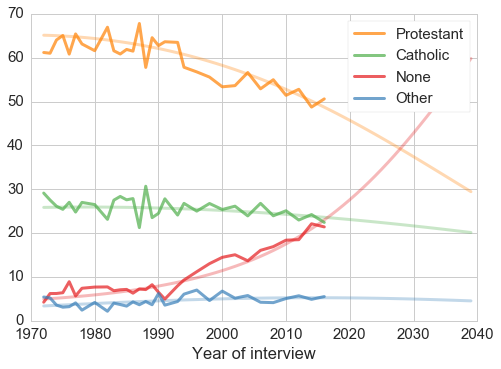

In [62]:
series_seq = [df[var] for var in varnames]

plot_predictions(series_seq)
plot_relig(grouped_year)
thinkplot.config(xlabel='Year of interview', loc='upper right')

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# solvers are newton-cg, sag, and lbfgs

model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
y = sample.relig4
X = sample[['c', 'a']].values
model.fit(X, y)
model.predict_proba(X).mean(axis=0)

array([ 0.58164368,  0.25650456,  0.04697153,  0.11488023])

In [64]:
y = sample.relig4
X = sample[['c', 'a', 'c2', 'a2', 'ac']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)

model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
model.fit(X_train, y_train)
pop_pred = model.predict_proba(X_test).mean(axis=0)
pop_pred

array([ 0.58137416,  0.2537615 ,  0.04777354,  0.1170908 ])

In [65]:
pmf = thinkstats2.Pmf(y_test)
pop_actual = np.array(pmf.Probs([1, 2, 3, 4]))
pop_actual

array([ 0.58149851,  0.2583004 ,  0.04642848,  0.11377262])

In [66]:
from sklearn.metrics import mutual_info_score

def kl_divergence(p, q):
    return sum(p * np.log(p/q))

In [67]:
kl_divergence(pop_actual, pop_pred)

0.00010694805762149128

## Fit a multinomial model

In [68]:
def get_factors(df):
    #return df[['c', 'c2', 'a', 'a2', 'ac']].values
    return df[['c', 'a']].values

def make_multi_model(df, y):
    """Fit a logistic regression model.
    
    df: DataFrame
    var: string name of dependent variable
    """
    model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
    X = get_factors(df)
    model.fit(X, y)
    return model

In [69]:
def predict_multi_model(age, model, year):
    """Make a prediction based on a fitted model.
    
    ???
    
    returns: Series that maps year of birth to predicted percentages
    """
    # TODO: consider resampling age and using
    # binomial rather than mean
    # age = thinkstats2.Resample(sample.age)
    cohort = year - age
    df = pd.DataFrame(dict(cohort=cohort, age=age))
    center_factors(df)
    X = get_factors(df)
    pred = model.predict_proba(X).mean(axis=0)
    index = ['prot', 'cath', 'other', 'none']
    return pd.Series(pred, index=index) * 100

In [70]:
train_year = 2016
train = sample[sample.year <= train_year]

In [71]:
model = make_multi_model(train, train.relig4)

In [72]:
age = sample.loc[sample.year==train_year, 'age']
predict_multi_model(age, model, 2016)

prot     50.110763
cath     23.404970
other     5.506665
none     20.977602
dtype: float64

In [73]:
predict_multi_model(age, model, 2026)

prot     44.369237
cath     21.551860
other     5.714221
none     28.364682
dtype: float64

In [74]:
def predict_by_year_multi(age, model, years):
    """Make predictions by year.
    
    age: Series of ages
    model_seq: list of fitted models
    years: list of years to generate predictions for
    """
    pred = pd.DataFrame(columns=varnames)
    for year in years:
        pred.loc[year] = predict_multi_model(age, model, year)
    return pred

In [75]:
years = np.arange(1972, 2040)
pred = predict_by_year_multi(age, model, years)

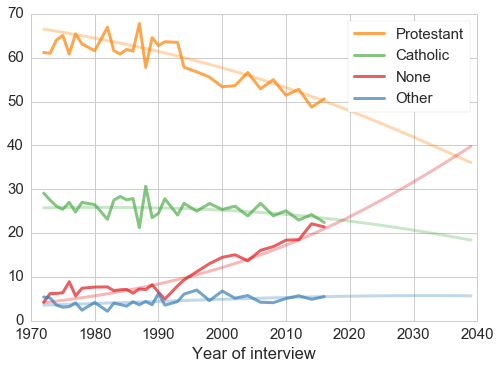

In [76]:
series_seq = [pred[var] for var in varnames]

plot_predictions(series_seq)
plot_relig(grouped_year)
thinkplot.config(xlabel='Year of interview', loc='upper right')

In [77]:
stop here

SyntaxError: invalid syntax (<ipython-input-77-f9ef205a8f26>, line 1)

## Belief in God

In [ ]:
varnames = ['strongbelief', 'belief', 'nobelief']

def create_belief_vars(df):
    """Creates columns for belief categories.
    
    df: DataFrame
    """
    df['nobelief'] = (df.god.isin([1, 2]))
    df['belief'] = (df.god.isin([3, 4, 5]))
    df['strongbelief'] = (df.god.isin([6]))

    df.loc[df.god.isnull(), varnames] = np.nan
    
create_belief_vars(sample)

In [ ]:
RED, PINK, _, _, LTBLUE, DKBLUE = sns.color_palette('RdBu', 6)
colors = [BLUE, PURPLE, RED]

In [ ]:
def plot_beliefs(grouped):
    """Plot belief categories.
    
    grouped: GroupBy object
    """
    labels = ['Strong belief', 'Belief', 'No belief']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

In [ ]:
plot_beliefs(grouped_year)
thinkplot.config(xlabel='Year', ylabel='Percent', loc='upper left')

In [ ]:
plot_beliefs(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='center left')

In [ ]:
make_model(sample, 'strongbelief').summary()

In [ ]:
make_model(sample, 'belief').summary()

In [ ]:
make_model(sample, 'nobelief').summary()

In [ ]:
model_seq = [make_model(sample, var) for var in varnames]
series_seq = [predict_cohort(results) for results in model_seq]

In [ ]:
plot_beliefs(grouped_cohort)
plot_predictions(series_seq)

thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='center left')

In [ ]:
predict_population(sample, model_seq, 2016)

In [ ]:
years = np.arange(1991, 2040)
df = predict_by_year(sample, model_seq, years)
df

In [ ]:
series_seq = [df[var] for var in varnames]

plot_predictions(series_seq)

plot_beliefs(grouped_year)
thinkplot.config(xlabel='Year of interview', loc='upper right')

## Confidence in people running organized religion

As far as the people running this institution [organized religion] are concerned, would you say you have a great deal of confidence, only some confidence, or hardly any confidence at all in them?

1. A great deal
2. Only some
3. Hardly any



In [ ]:
sum(sample.conclerg.isnull())

In [ ]:
varnames = ['confident', 'someconf', 'noconf']

def create_conf_vars(df):
    """Creates columns for confidence in religion categories.
    
    df: DataFrame
    """
    df['confident'] = (df.conclerg == 1)
    df['someconf'] = (df.conclerg == 2)
    df['noconf'] = (df.conclerg == 3)

    df.loc[df.conclerg.isnull(), varnames] = np.nan
    
    
create_conf_vars(sample)


In [ ]:
def plot_conf(grouped):
    """Plot confidence in religion categories.
    
    grouped: GroupBy object
    """
    labels = ['Great deal', 'Only some', 'Hardly any']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

In [ ]:
plot_conf(grouped_year)
thinkplot.config(xlabel='Year of interview', ylabel='Percent', loc='center right')

In [ ]:
plot_conf(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

In [ ]:
make_model(sample, 'confident').summary()

In [ ]:
make_model(sample, 'someconf').summary()

In [ ]:
make_model(sample, 'noconf').summary()

In [ ]:
model_seq = [make_model(sample, var) for var in varnames]
series_seq = [predict_cohort(results) for results in model_seq]


In [ ]:
plot_conf(grouped_cohort)
plot_predictions(series_seq)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

In [ ]:
predict_population(sample, model_seq, 2016)

In [ ]:
years = np.arange(1973, 2040)
df = predict_by_year(sample, model_seq, years)

In [ ]:
series_seq = [df[var] for var in varnames]

plot_predictions(series_seq)

plot_conf(grouped_year)
thinkplot.config(xlabel='Year of interview', loc='upper right')

## Bible

Which one of these statements comes closest to describing your feelings about the Bible? 

1. The Bible is the actual word of God and is to be taken literally, word for word

2. The Bible is the inspired word of God but not everything should be taken literally, word for word

3. The Bible is an ancient book of fables, legends, history and moral precepts recorded by man

In [ ]:
sum(sample.bible.isnull())

In [ ]:
varnames = ['word', 'inspired', 'legends']

def create_bible_vars(df):
    """Creates columns for bible interpretation categories.
    
    df: DataFrame
    """
    df['word'] = (df.bible == 1)
    df['inspired'] = (df.bible == 2)
    df['legends'] = (df.bible == 3)

    df.loc[df.bible.isnull(), varnames] = np.nan
    
create_bible_vars(sample)

In [ ]:
def plot_bible(grouped):
    """Plot bible interpretation categories.
    
    grouped: GroupBy object
    """
    labels = ['Literal', 'Inspired', 'Legends']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

In [ ]:
plot_bible(grouped_year)
thinkplot.config(xlabel='Year of interview', ylabel='Percent', loc='center right')

In [ ]:
plot_conf(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

In [ ]:
make_model(sample, 'word').summary()

In [ ]:
make_model(sample, 'inspired').summary()

In [ ]:
make_model(sample, 'legends').summary()

In [ ]:
model_seq = [make_model(sample, var) for var in varnames]
series_seq = [predict_cohort(results) for results in model_seq]

In [ ]:
plot_bible(grouped_cohort)
plot_predictions(series_seq)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

In [ ]:
predict_population(sample, model_seq, 2016)

In [ ]:
years = np.arange(2017, 2040)
df = predict_by_year(sample, model_seq, years)

In [ ]:
series_seq = [df[var] for var in varnames]

plot_predictions(series_seq)

plot_bible(grouped_year)
thinkplot.config(xlabel='Year of interview', loc='upper right')